# Statistical models to estimate average treatment effect for each mine 

In [ ]:
#load packages
library(tidyverse)
library(INLA)
library(gstat)
library(sp)
library(repr)
library(cowplot)
library(scales)
library(MetBrewer)
library(DHARMa)

In [ ]:
##paths to all the datasets - deal with one at a time as very large memeory requirments
path = "PATH"
psm <- paste0(path, "dfs/psm_mines_rs_25/")
rand <- paste0(path, "dfs/rand_mines_rs_25/")
nlel <- paste0(path, "dfs/psm_mines_nlel_rs_25/")
cem <- paste0(path, "dfs/cem_mines_rs_25/")
psm10 <- paste0(path,"dfs/psm_mines_rs_25_10km/")
psm50 <- paste0(path, "dfs/psm_mines_rs_25_50km/")

In [ ]:
##read in list of mines and when the became active
ma <- read_csv(paste(path,"dfs/mine_tyr.csv",sep="/"), show_col_types = FALSE) %>% arrange(mine)
mines <- ma$mine

In [ ]:
#create a list to loop through
m_list1 = c(1:22)

In [ ]:
##read in the mine dataframes, filter to just five years after treatment and standerdise covars and set factors as factors
stand <- function(x){ (x - mean(x)) / sd(x)}
m = list()
for (i in m_list1) {
    m[[i]] <- read_csv(paste0(psm, mines[i],'.csv'), show_col_types = FALSE) %>% 
                                                    filter(year <= (min(year)+4)) %>%
                                                        mutate(tc_s = stand(tc), slope_s = stand(slope), 
                                                        pa_f = as.factor(round(pa)), tc_sd_s = stand(tc_sd),
                                                        trtf = as.factor(trt_con),
                                                        xkm = x/1000, ykm = y/1000, mine = replace(mine, is.na(mine),0), 
                                                        loss_m = round(loss_tcw),
                                                        YearSeq = as.numeric(as.factor(year)),  yrf = as.factor(YearSeq)) ##create the year groups for the saptiotemporal model
    gc()
}

In [24]:
for(i in m_list1){
    print(paste(i,length(m[[i]]$ID)))
}

[1] "1 15830"
[1] "2 4640"
[1] "3 2350"
[1] "4 2550"
[1] "5 2540"
[1] "6 3160"
[1] "7 16530"
[1] "8 1900"
[1] "9 1990"
[1] "10 4850"
[1] "11 6710"
[1] "12 4550"
[1] "13 3500"
[1] "14 9140"
[1] "15 2130"
[1] "16 5110"
[1] "17 2660"
[1] "18 1800"
[1] "19 5950"
[1] "20 3150"
[1] "21 5140"
[1] "22 1404"


In [25]:
##create a list of coordinates of centroids of the pixels. These are then used to build meshes of triangles
xys = list()
xys_1yr = list()
meshs = list()

for(i in m_list1){
    df <- m[[i]]
    df1yr <- filter(df, year == min(year))
    xys[[i]] <- cbind(df$xkm, df$ykm)
    xys_1yr[[i]] <- cbind(df1yr$xkm, df1yr$ykm)
    #max edge (inner, outer edge)-  size of triangles, cut off - points closers together than this have same spatial effect
    meshs[[i]] <- inla.mesh.2d(loc = xys[[i]], max.edge = c(4,10), cutoff = 4) 
}


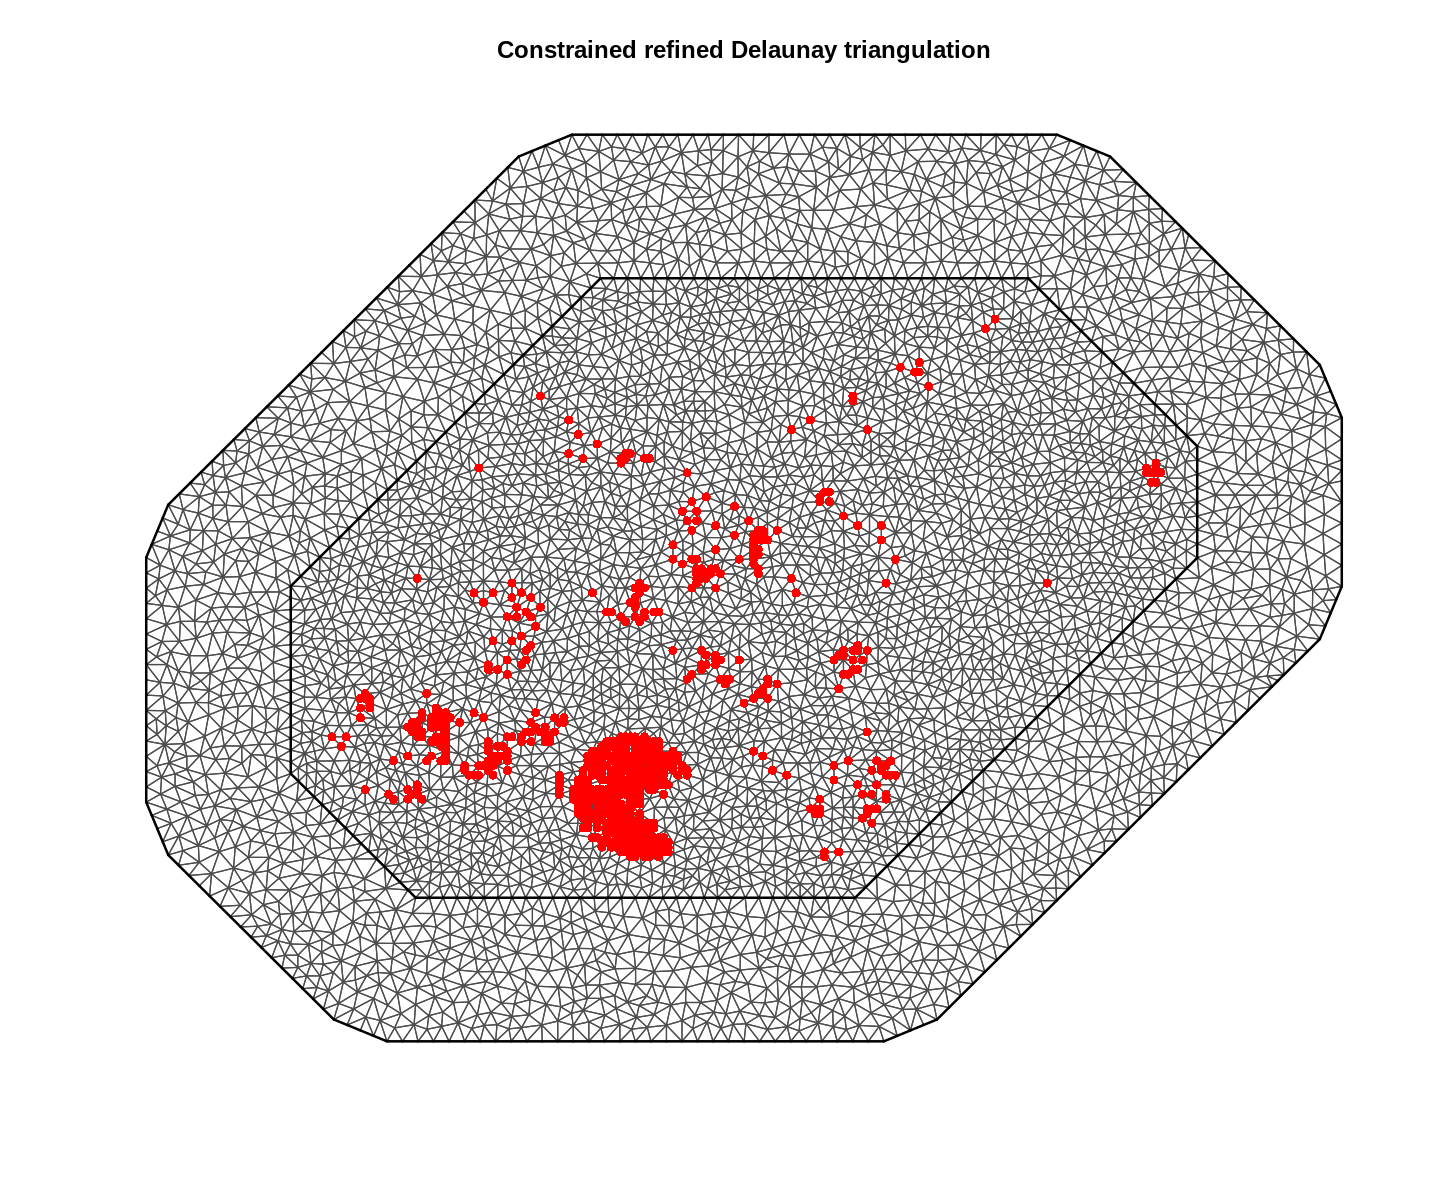

In [36]:
##plot of one mesh and the centriods
options(repr.plot.width=12, repr.plot.height=10)
plot(meshs[[13]])
points(xys_1yr[[13]][,1], xys_1yr[[13]][,2], col='red', pch = 16)

In [13]:
#make spde, the A matrix, and the w index for each mine 

spdes = list()
As = list()
Ws = list()

##loop through mines
for(i in m_list1){
    df <- m[[i]]
    NYears <- length(unique(df$YearSeq)) ## nubmer of groups
    spdes[[i]] <- inla.spde2.pcmatern(meshs[[i]], 
                             prior.range = c(50, 0.05), ## 0.05 probanilty that the range (extenet of spaital smoothing) will be larger than 50
                                                            # too small a range can cause overfitting 
                             prior.sigma = c(1, 0.05)) ## 0.05 probability that sigma is smaller than 1 - this needs to vary for some mines for models to fit
    
    As[[i]] <- inla.spde.make.A(meshs[[i]], loc = xys[[i]], group = df$YearSeq, n.group = NYears) ## Make A matrix with year groups
    Ws[[i]] <- inla.spde.make.index(name = 'w', n.spde  = spdes[[i]]$n.spde, n.group = NYears) ## Make index for spaitl random feild for W to estimated
    gc()

}

In [14]:
##make a model matrix and a formula for each mine
##store model matrix in a dataframe (for INLA) and a matrix for creating mdoel predictions later on

Xms = list()
forms = list()
X.as.mat = list()

for(i in m_list1){
    df <- m[[i]]
    if ('1' %in% df$pa_f) { #only include PA if any pixels are in one
        X <- model.matrix(~ trtf*yrf + tc_s + tc_sd_s + slope + pa_f, data = df)
    }else{
        X <- model.matrix(~ trtf*yrf + tc_s + tc_sd_s + slope, data = df)
    }
    colnames(X) <- str_replace(colnames(X),':','_') ##names need reformated as INLA can't have ':' in covar names
    X.as.mat[[i]] <- as.matrix(X)
    Xms[[i]] <- as.data.frame(X)
    forms[[i]] <- formula(paste('loss_m ~ -1 + Intercept +', paste(colnames(X[,-1]), collapse=' + '), 
                                ' + f(w,  model = spde, group = w.group, control.group = list(model="exchangeable")) + f(ID, model = "iid")'))
    gc()
}

In [15]:
##make a stack for each mine - this is how inla needs all data for SPDE models

stacks = list()

for(i in m_list1){
    df <- m[[i]]
    N <- nrow(df)
    A <- As[[i]]
    w <- Ws[[i]]
    Xm <- Xms[[i]]
    stacks[[i]] <- inla.stack(tag = "Fit", data = list(loss_m = df$loss_m), 
                              A = list(1, 1, 1, A), ##this lsit needs to match list of effects - sptial feild is connected to the A matrix
                              effects = list(Intercept = rep(1, N),  #Use our own intercept
                                                  X    = Xm[,-1], #Covariates, except for the intercept
                                                  ID  = df$ID, ##pixel ID
                                                  w = w))  ##Spatial random feild
    
    
    gc()

}

## Zero inflated negative binomial regressions

In [ ]:
##zero inflated negative bionmial model in this formualation only uses an intercept (no covariates) for binomial part.  

##run the mdoel for each mine and store model object in a list

models = list()

for(i in m_list1){
    f <- forms[[i]]
    spde <- spdes[[i]]
    stack <- stacks[[i]]
    tryCatch({
    models[[i]] <- inla(f, family = "zeroinflatednbinomial1", data = inla.stack.data(stack),
                        control.compute = list(dic = TRUE, config = TRUE), control.predictor = list(A = inla.stack.A(stack)))
    }, error=function(e){})
    gc()
}

In [ ]:
##save the models as an Rdata object
#save(models, file = paste0(psm,'ZINB_models.rda'))

In [14]:
#load(file = paste0(psm,'ZINB_models.rda'))

In [18]:
##simualte data from the model - this draws from the positerior distrubtion of the latent effects
##output is beta values and spatil effects
NSim <- 4000
Sim_datas = list()

for (i in m_list1){
    tryCatch({
    Sim_datas[[i]] <- inla.posterior.sample(n = NSim, result = models[[i]])
    }, error=function(e){})
    gc()
}

In [19]:
##subset simulations for calcuating residuals 

NSim2 <- 1000

Sim_datas2 = list()

for (i in m_list1){
    tryCatch({
    Sim_datas2[[i]] <- Sim_datas[[i]][1:NSim2]
    }, error=function(e){})
    gc()
}


In [17]:
##created simualted responses based on draws from the positerior
# the repsosne has to be simualted based on the beta values and sptial effects

Ysims = list()

for (i in m_list1){
    N  <- nrow(m[[i]])
    Ysim <- matrix(nrow = N, ncol = NSim2)
    mus  <- matrix(nrow = N, ncol = NSim2)
    Xmat <- X.as.mat[[i]]  
    A    <- as.matrix(As[[i]])
    tryCatch({
    Beta_names <- lapply(rownames(models[[i]]$summary.fixed),function(x){paste0(x,':1')}) ##get covars names in right format
    N1 <- dim(As[[i]])[2] ##get number of Ws from A matrix 
    w_names <- paste0("w:", 0:N1) ##list of W indexs
    SimData <- Sim_datas2[[i]]
    
    for (j in 1:NSim2){
        Betas <- SimData[[j]]$latent[rownames(SimData[[j]]$latent) %in% Beta_names] ##select beta values from sim data
        wi    <- SimData[[j]]$latent[rownames(SimData[[j]]$latent) %in% w_names] ##select sptial effects 
        theta  <- SimData[[j]]$hyperpar[1] 
        pi    <- SimData[[j]]$hyperpar[2]
        mus[,j]   <-  exp(Xmat %*% Betas + (A %*% wi)) #calcuate fitted value and take expoentant to get mu - 
                                                        #fixed part of the model plus the spatio-temporal random effect
        Ysim[,j]  <-  rzinegbin(n = N, size = theta, munb = mus[,j], pstr0 = pi) ##simulate the response
    }
    Ysims[[i]] <- Ysim
        },error=function(e){})
    gc()
}

In [18]:
##save the simulated response datasets for each mine
for (i in m_list1) {
    write.csv(as.data.frame(Ysims[[i]]), paste(psm,"/sims/Ysim_", mines[i], ".csv", sep=""), row.names = FALSE)
}

In [19]:
##save the fitted values
for (i in m_list1) {
    write.csv(as.data.frame(models[[i]]$summary.fitted.values[1:nrow(m[[i]]),]), 
              paste(psm,"/sims/fitted_", mines[i], ".csv", sep=""), row.names = FALSE)
} 

## Check results with DHARMa residuals

In [10]:
##read in all fitted values and simluated repsosnes
fit <- list()
sim <- list()

for (i in m_list1) {
    fit[[i]] <- read_csv(paste0(psm, "/sims/fitted_", mines[i],'.csv'), show_col_types = FALSE)
    sim[[i]] <- read_csv(paste0(psm, "/sims/Ysim_", mines[i],'.csv'), show_col_types = FALSE)
}

In [13]:
###create DHARMa residuals
res = list()

for (i in m_list1) {
    res[[i]] <- createDHARMa(simulatedResponse = as.matrix(sim[[i]]), 
                           observedResponse = m[[i]]$loss_m,
                           fittedPredictedResponse = fit[[i]]$mean,
                           integerResponse = TRUE)
}

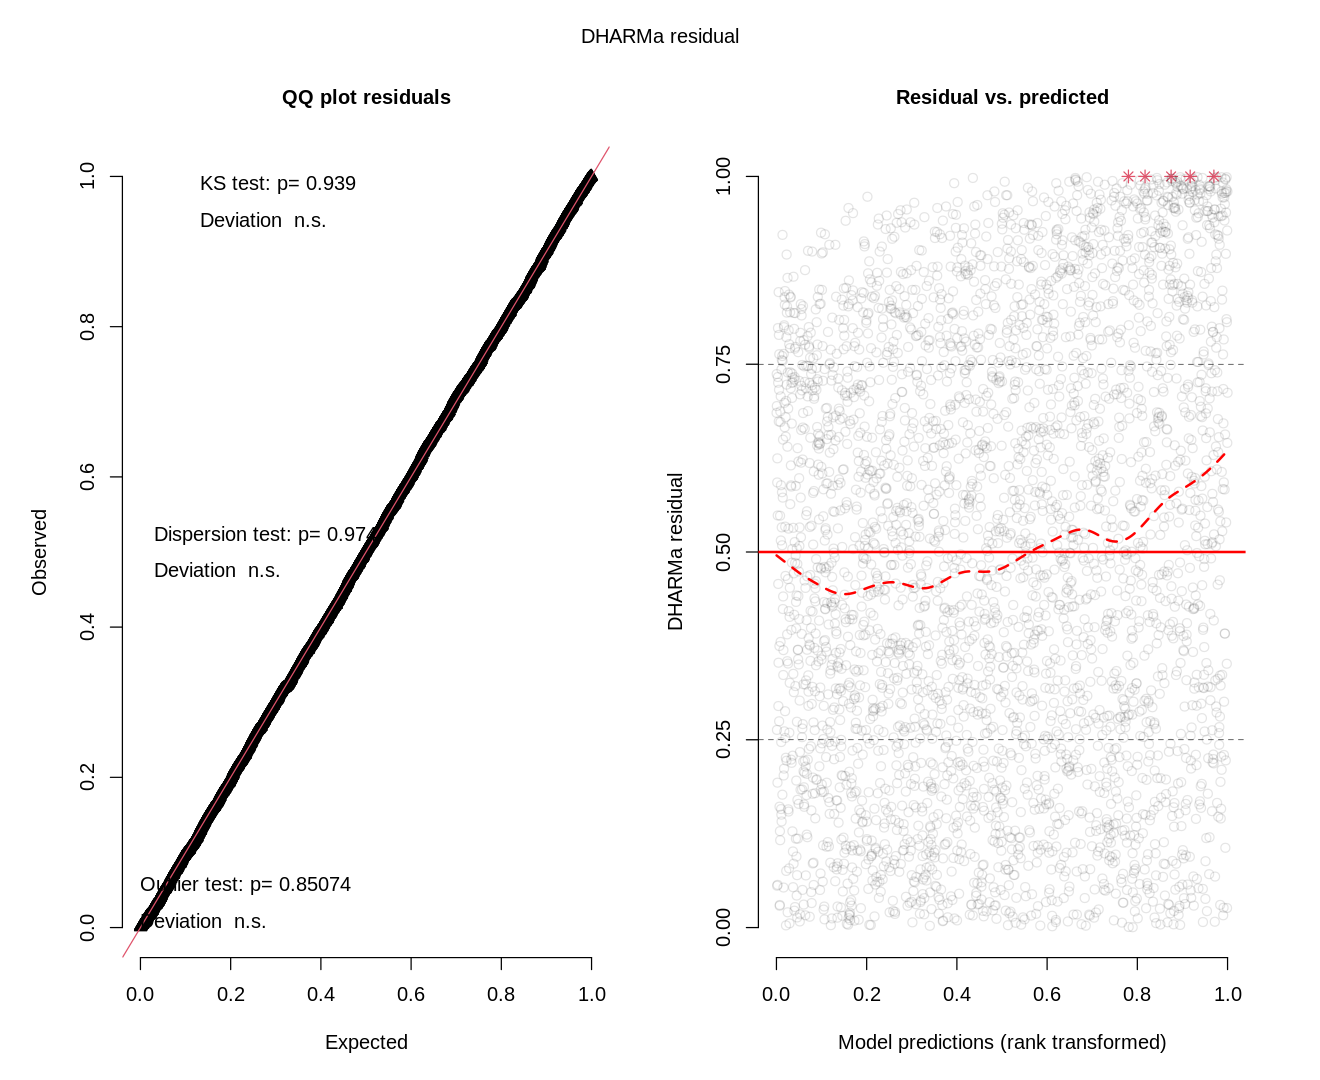


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = 0.99394, p-value = 0.664
alternative hypothesis: two.sided


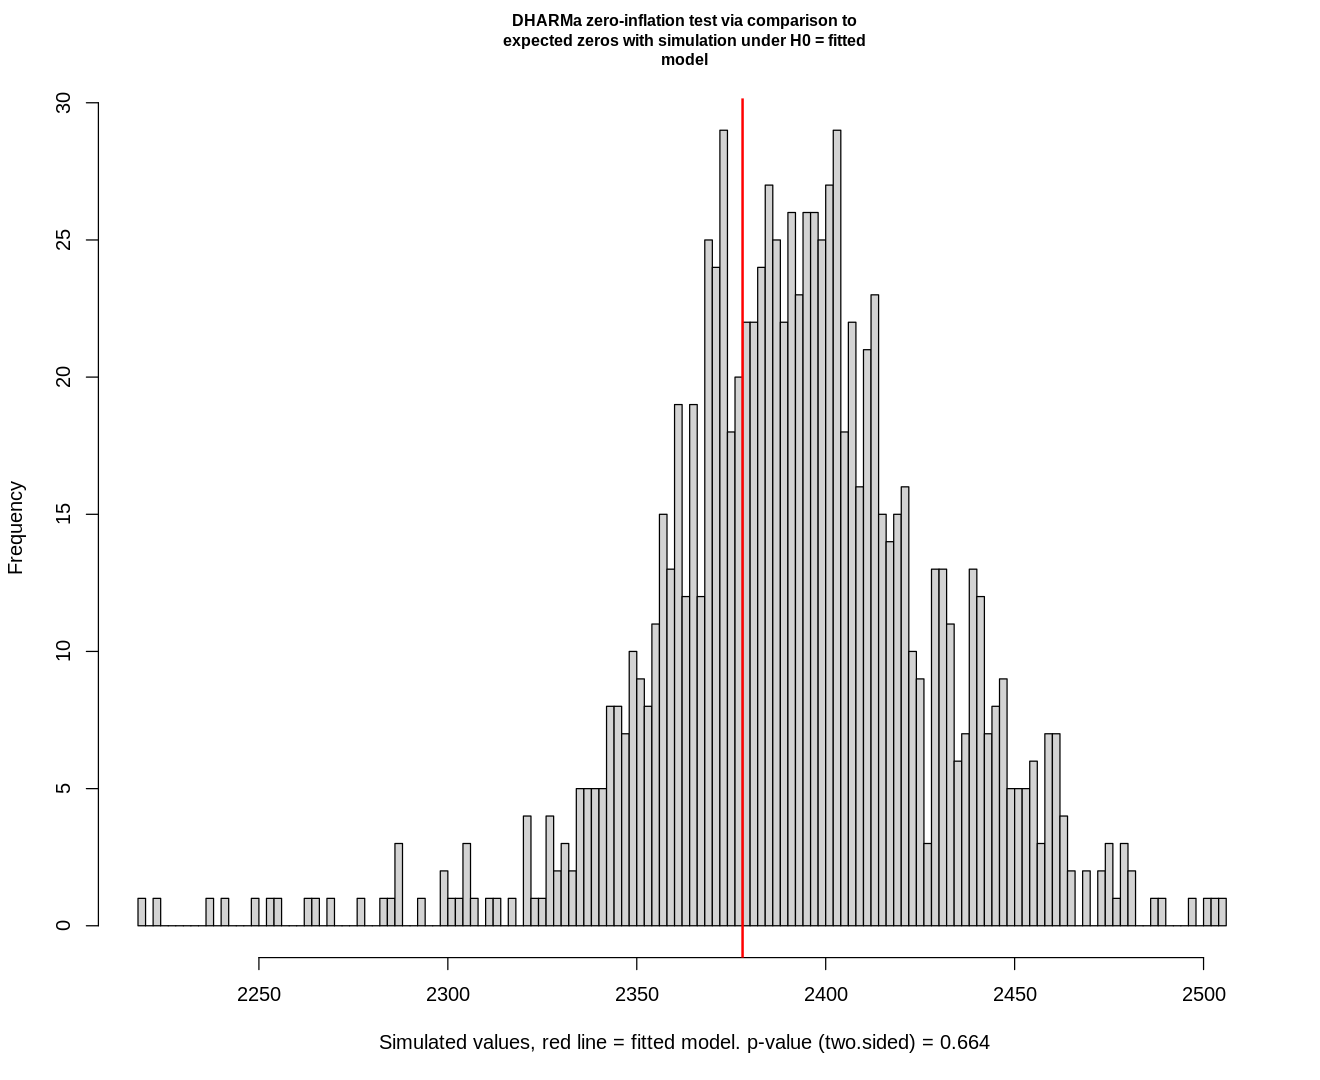

In [108]:
options(repr.plot.width=11, repr.plot.height=9)
plot(res[[13]])
testZeroInflation(res[[13]])

In [19]:
##calcaute Pearsons residuals and add Sim res from DHARAMA package
##create a single df for all mines 

res_df = data.frame()

for(i in m_list1){
    df <- m[[i]]
    N <- nrow(df)
    tryCatch({
        m1 <- models[[i]]
        theta.pd <- m1$marginals.hyperpar$`size for nbinomial zero-inflated observations`
        theta <- inla.emarginal(function(x) x, theta.pd)
        pi.pd <- m1$marginals.hyperpar$`zero-probability parameter for zero-inflated nbinomial_1`
        Pi <- inla.emarginal(function(x) x, pi.pd)          
                                
        df<- df %>% transmute(ID = ID, mine = mine, year = year, xkm = xkm, ykm = ykm, trt_con = trt_con, loss_m = loss_m, 
                           mu = m1$summary.fitted.values[1:N,"mean"], ExpY = (1 - Pi) * mu, 
                           varY = (1 - Pi) * (mu + (mu^2/theta)) + mu^2 *(Pi^2 + Pi), 
                           PR = (loss_m - ExpY) / sqrt(varY), sim_res = res[[i]]$scaledResiduals)
                             
        res_df = bind_rows(res_df, df)                   
    }, error=function(e){})
}

In [25]:
##save resdiauls for all mines 
#write.csv(res_df, 'results/ZINB_residuals_PSM.csv')

In [ ]:
res_df <- read_csv('results/ZINB_residuals_PSM.csv')

In [20]:
##calcuate the effects for treated and control and the difference between them for each mine
## get annual and overall effects save as a single dataframe for all mines

beta_df = data.frame()

for (i in 1:length(models)){
    tryCatch({
        sims = Sim_datas[[i]]
        Beta_names <- lapply(rownames(models[[i]]$summary.fixed),function(x){paste0(x,':1')}) ##get covars names in right format
        betas = matrix(nrow=NSim, ncol = length(Beta_names))
        colnames(betas) <- rownames(models[[i]]$summary.fixed)
        for(j in 1:NSim){
            betas[j,] <-  sims[[j]]$latent[rownames(sims[[j]]$latent) %in% Beta_names]
           } 
        beta_df1 <- as.data.frame(betas) %>%  
                                    #esimtates on data scale untreated        
                            mutate(untrt_yr1 = exp(Intercept), untrt_yr2 = exp(Intercept + yrf2), untrt_yr3 = exp(Intercept + yrf3), 
                                    untrt_yr4 = exp(Intercept + yrf4), untrt_yr5 = exp(Intercept + yrf5),
                                    
                                    #estimates on data scale treated                
                                    trt_yr1 = exp(Intercept + trtf1), trt_yr2 = exp(Intercept + trtf1 + yrf2 + trtf1_yrf2), 
                                    trt_yr3 = exp(Intercept + trtf1 + yrf3 + trtf1_yrf3), trt_yr4 = exp(Intercept + trtf1 + yrf4 + trtf1_yrf2), 
                                    trt_yr5 = exp(Intercept + trtf1 + yrf5 + trtf1_yrf2),
                                    
                                    #difference on model scale                
                                    ms_dif_yr1 = trtf1, ms_dif_yr2 = trtf1 + trtf1_yrf2, ms_dif_yr3 = trtf1 + trtf1_yrf3,
                                    ms_dif_yr4 = trtf1 + trtf1_yrf4, ms_dif_yr5 = trtf1 + trtf1_yrf5,
                                                
                                    #difference on data scale                
                                    ds_dif_yr1 = trt_yr1 - untrt_yr1, ds_dif_yr2 =  trt_yr2 - untrt_yr2,  ds_dif_yr3 = trt_yr3 - untrt_yr3,  
                                    ds_dif_yr4 =  trt_yr4 - untrt_yr4, ds_dif_yr5 =  trt_yr5 - untrt_yr5,  
                                   
                                    ##difference for whole time period 
                                    ms_dif_all = ms_dif_yr1 + ms_dif_yr2 + ms_dif_yr3 + ms_dif_yr4 + ms_dif_yr5,
                                   
                                   
                                    ds_dif_all = ds_dif_yr1 + ds_dif_yr2 + ds_dif_yr3 + ds_dif_yr4 + ds_dif_yr5,
                                    
                                    mine = mines[i])
        beta_df <- bind_rows(beta_df, beta_df1)
         }, error=function(e){})
    gc()
}

In [21]:
##repeat the above steps for Mine 22 which only has three years of response

beta_df22 = data.frame()

for (i in c(22)){
    tryCatch({
        sims = Sim_datas[[i]]
        Beta_names <- lapply(rownames(models[[i]]$summary.fixed),function(x){paste0(x,':1')}) ##get covars names in right format
        betas = matrix(nrow=NSim, ncol = length(Beta_names))
        colnames(betas) <- rownames(models[[i]]$summary.fixed)
        for(j in 1:NSim){
            betas[j,] <-  sims[[j]]$latent[rownames(sims[[j]]$latent) %in% Beta_names]
           } 
        beta_df1 <- as.data.frame(betas) %>%  
                                    #esimtates on data scale untreated        
                            mutate(untrt_yr1 = exp(Intercept), untrt_yr2 = exp(Intercept + yrf2), untrt_yr3 = exp(Intercept + yrf3), 
                                    
                                    #estimates on data scale treated                
                                    trt_yr1 = exp(Intercept + trtf1), trt_yr2 = exp(Intercept + trtf1 + yrf2 + trtf1_yrf2), 
                                    trt_yr3 = exp(Intercept + trtf1 + yrf3 + trtf1_yrf3),
                                    
                                    #difference on model scale                
                                    ms_dif_yr1 = trtf1, ms_dif_yr2 = trtf1 + trtf1_yrf2, ms_dif_yr3 = trtf1 + trtf1_yrf3,
                                                
                                    #difference on data scale                
                                    ds_dif_yr1 = trt_yr1 - untrt_yr1, ds_dif_yr2 =  trt_yr2 - untrt_yr2,  ds_dif_yr3 = trt_yr3 - untrt_yr3, 
                                   
                                    ##difference for whole time period 
                                    ms_dif_all = ms_dif_yr1 + ms_dif_yr2 + ms_dif_yr3,
                                   
                                   
                                    ds_dif_all = ds_dif_yr1 + ds_dif_yr2 + ds_dif_yr3,
                                    
                                    mine = mines[i])
        beta_df22 <- bind_rows(beta_df22, beta_df1)
         }, error=function(e){})
    gc()
}

In [22]:
##combine
beta_df <- bind_rows(beta_df, beta_df22) 

In [27]:
##save results for each model
#write.csv(beta_df, 'results/ZINB_posterior_samples_cem.csv')  
#write.csv(beta_df, 'results/ZINB_posterior_samples_nlel.csv')  
#write.csv(beta_df, 'results/ZINB_posterior_samples_rand.csv')  
#write.csv(beta_df, 'results/ZINB_posterior_samples_psm.csv')  

In [ ]:
##read in the different datasets
beta_df_psm <- read_csv('results/ZINB_posterior_samples_psm.csv', show_col_types = FALSE)   %>% mutate(method = 'PSM')
beta_df_nlel <- read_csv('results/ZINB_posterior_samples_nlel.csv',show_col_types = FALSE)   %>% mutate(method = 'nLEL')
beta_df_cem <- read_csv('results/ZINB_posterior_samples_cem.csv', show_col_types = FALSE) %>% mutate(method = 'CEM')
beta_df_rand <- read_csv('results/ZINB_posterior_samples_rand.csv', show_col_types = FALSE) %>% mutate(method = 'Random')

In [5]:
##combine
beta_df <- bind_rows(beta_df_psm, beta_df_nlel, beta_df_cem, beta_df_rand) %>%
                mutate(method = factor(method, levels = c('PSM', 'nLEL', 'CEM', 'Random')))

In [ ]:
## convert dataframe of samples to results dataframes -
#get the mean and HPD for 95 and 80 CIs
res_mscale = beta_df %>% 
                select(ms_dif_all, mine, method) %>% 
                group_by(method, mine) %>%
                        summarize(mean = inla.emarginal(function(x) x, density(ms_dif_all)), 
                                                        low_95 = inla.hpdmarginal(0.95, density(ms_dif_all))[1], 
                                                        high_95 = inla.hpdmarginal(0.95, density(ms_dif_all))[2],
                                                        low_80 = inla.hpdmarginal(0.80, density(ms_dif_all))[1], 
                                                        high_80 = inla.hpdmarginal(0.80, density(ms_dif_all))[2]) %>%
                        mutate(mine = factor(mine, levels = rev(mine)), ) %>%
                                  ungroup()

In [ ]:
## convert dataframe of samples to results dataframes
#get the mean and HPD for 95 and 80 CIs

res_dscale = beta_df %>% 
                select(ds_dif_all, mine, method) %>% 
                group_by(method, mine) %>%
                        summarize(mean = inla.emarginal(function(x) x, density(ds_dif_all)), 
                                                        low_95 = inla.hpdmarginal(0.95, density(ds_dif_all))[1], 
                                                        high_95 = inla.hpdmarginal(0.95, density(ds_dif_all))[2],
                                                        low_80 = inla.hpdmarginal(0.80, density(ds_dif_all))[1], 
                                                        high_80 = inla.hpdmarginal(0.80, density(ds_dif_all))[2]) %>%
                                                          mutate(mine = factor(mine, levels = rev(mine))) %>%

                                  ungroup()

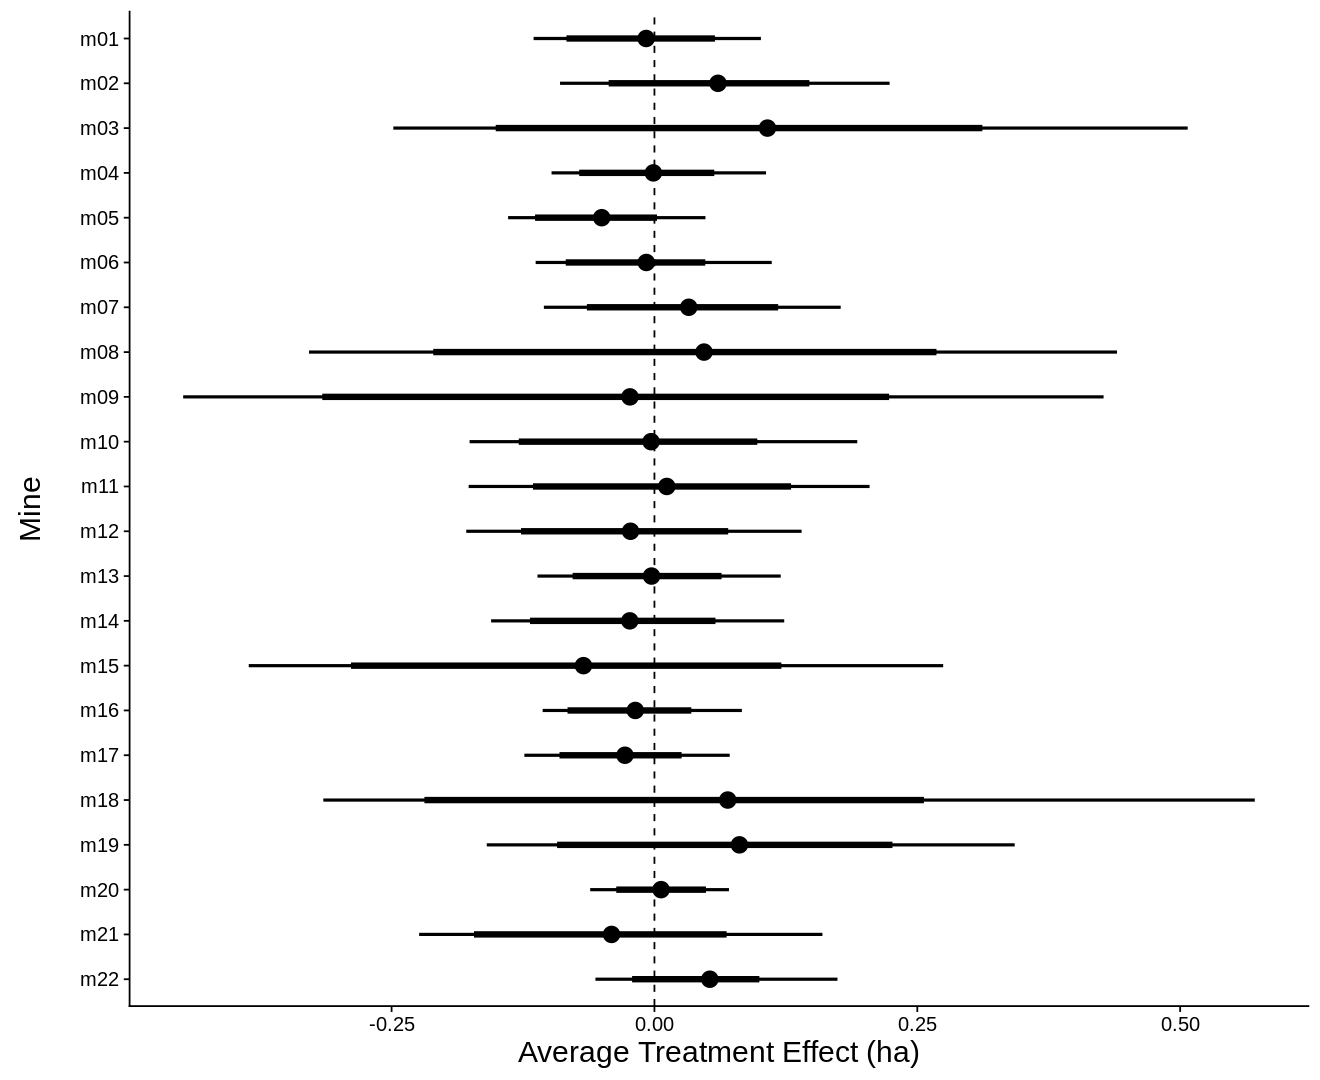

In [15]:
options(repr.plot.width=11, repr.plot.height=9)

##plot data scale results for jsut the main analysis (figure 3 in paper)

(dscale_plot <- res_dscale %>%
                 filter(method == 'PSM') %>%

 ggplot() +
 geom_linerange(aes(x = (mine), ymin = low_80/1e4, ymax = high_80/1e4), size = 1.8) + 
 geom_pointrange(aes(x = (mine), y = mean/1e4, ymin = low_95/1e4, ymax = high_95/1e4), size = .9) + 
 geom_hline(yintercept = 0, linetype = 2) +
 coord_flip() +
 theme_cowplot() +
 labs(x = 'Mine', y = 'Average Treatment Effect (ha)' ) +
 theme(text = element_text(size = 18), 
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 5))) +
         scale_y_continuous(labels = comma) 
)

In [16]:
ggsave(dscale_plot, 'png', filename = 'figures/figure_3.png', width = 11, height = 9)

In [18]:
##set pallette for plot
pal2 <- as.list(met.brewer(name="Egypt", type="discrete"))

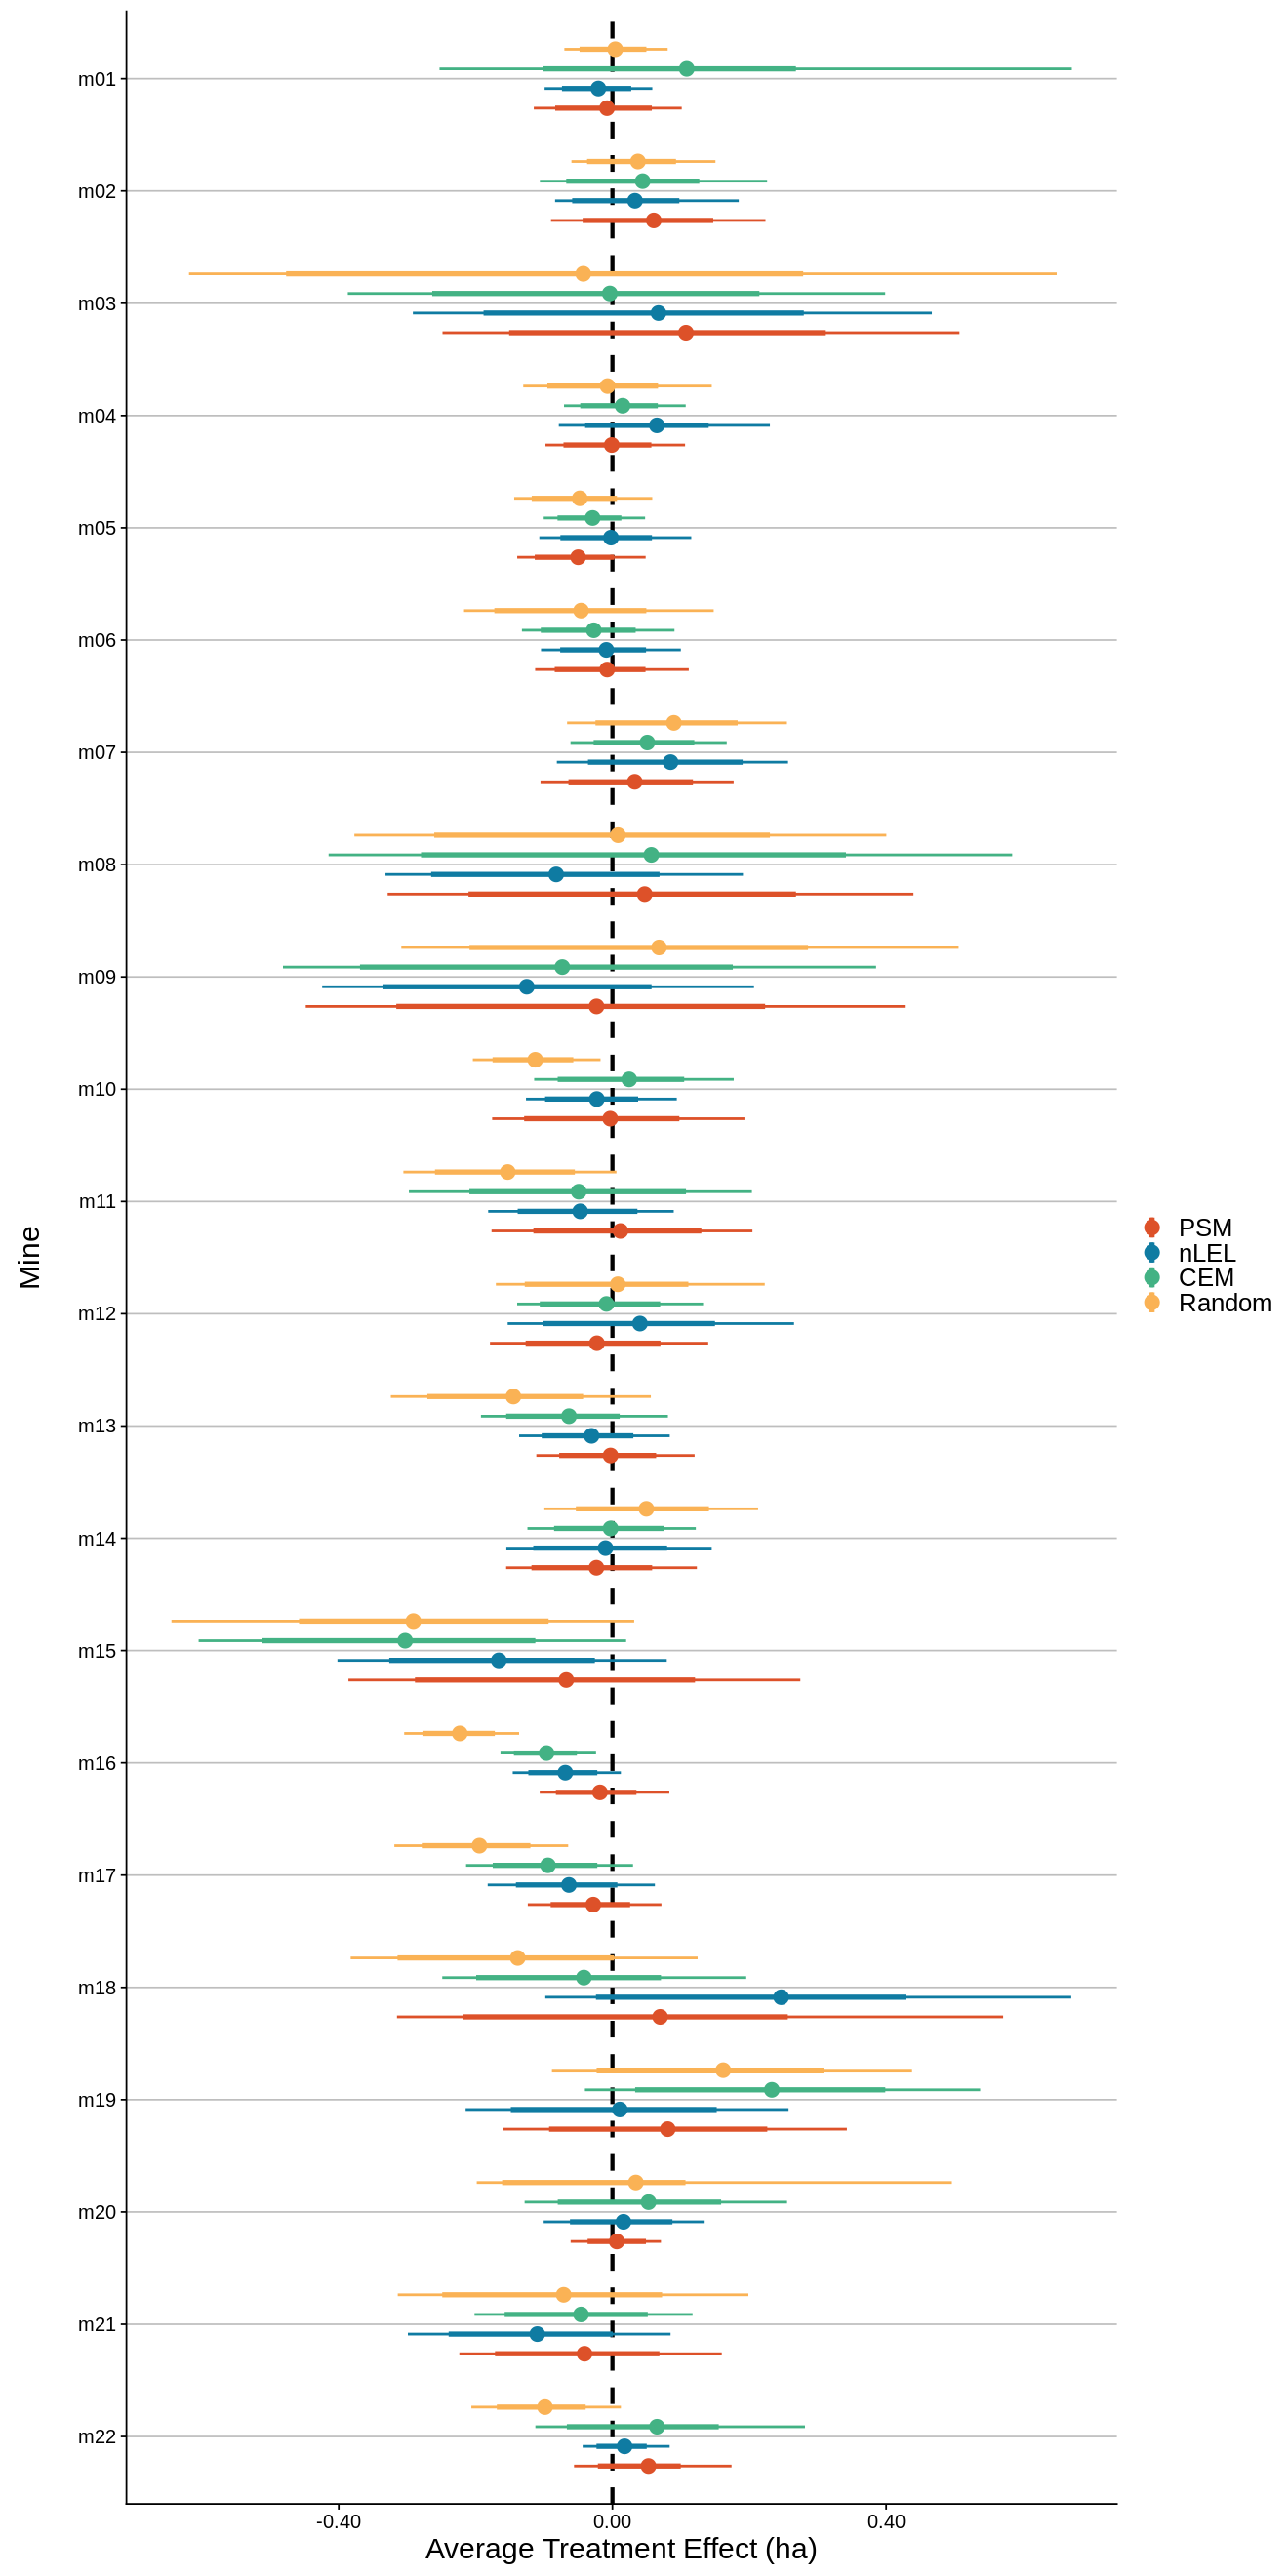

In [19]:
options(repr.plot.width=11, repr.plot.height=22)

##plot data scale results comapring methods

(dscale_plot2 <- res_dscale %>%
 ggplot() +
 geom_hline(yintercept = 0, linetype = 2, size = 1.2) +
 geom_linerange(aes(x = (mine), ymin = low_80/1e4, ymax = high_80/1e4, colour = method),  position = position_dodge(width = 0.7), size = 1.5) + 
 geom_pointrange(aes(x = (mine), y = mean/1e4, ymin = low_95/1e4, ymax = high_95/1e4, colour = method),  position = position_dodge(width = 0.7), size = 0.8) + 
 coord_flip() +
 theme_cowplot() +
 labs(x = 'Mine', y = 'Average Treatment Effect (ha)' ) +
 theme(text = element_text(size = 18), 
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 5)), 
            legend.title = element_blank(), 
        panel.grid.major.y = element_line(colour = "grey")) +
         scale_y_continuous(labels = comma)  +
         scale_colour_manual(values = pal2)
)

In [20]:
ggsave(dscale_plot2, 'png', filename = 'figures/figure_S5.png', width = 11, height = 14)

In [ ]:
## convert dataframe of samples to results dataframes 
#create esimate for each year  

res_dscale_yr = beta_df %>% select(ds_dif_yr1, ds_dif_yr2, ds_dif_yr3, ds_dif_yr4, ds_dif_yr5, mine, method) %>% 
                group_by(method, mine) %>%
                pivot_longer(cols = starts_with('ds'), names_to = 'year', names_prefix = 'ds_dif_yr', values_to = 'samples') %>%
                group_by(method, mine, year) %>%
                drop_na() %>%  ##removes the missing years for mine 22
                summarize(mean = inla.emarginal(function(x) x, density(samples)), low_95 = inla.hpdmarginal(0.95, density(samples))[1], 
                          high_95 = inla.hpdmarginal(0.95, density(samples))[2],
                          low_80 = inla.hpdmarginal(0.80, density(samples))[1], high_80 = inla.hpdmarginal(0.80, density(samples))[2]) %>%
                left_join(ma, by = 'mine') %>% mutate(year_real = as.numeric(year) + (active-1)) %>%
                ungroup()
                          

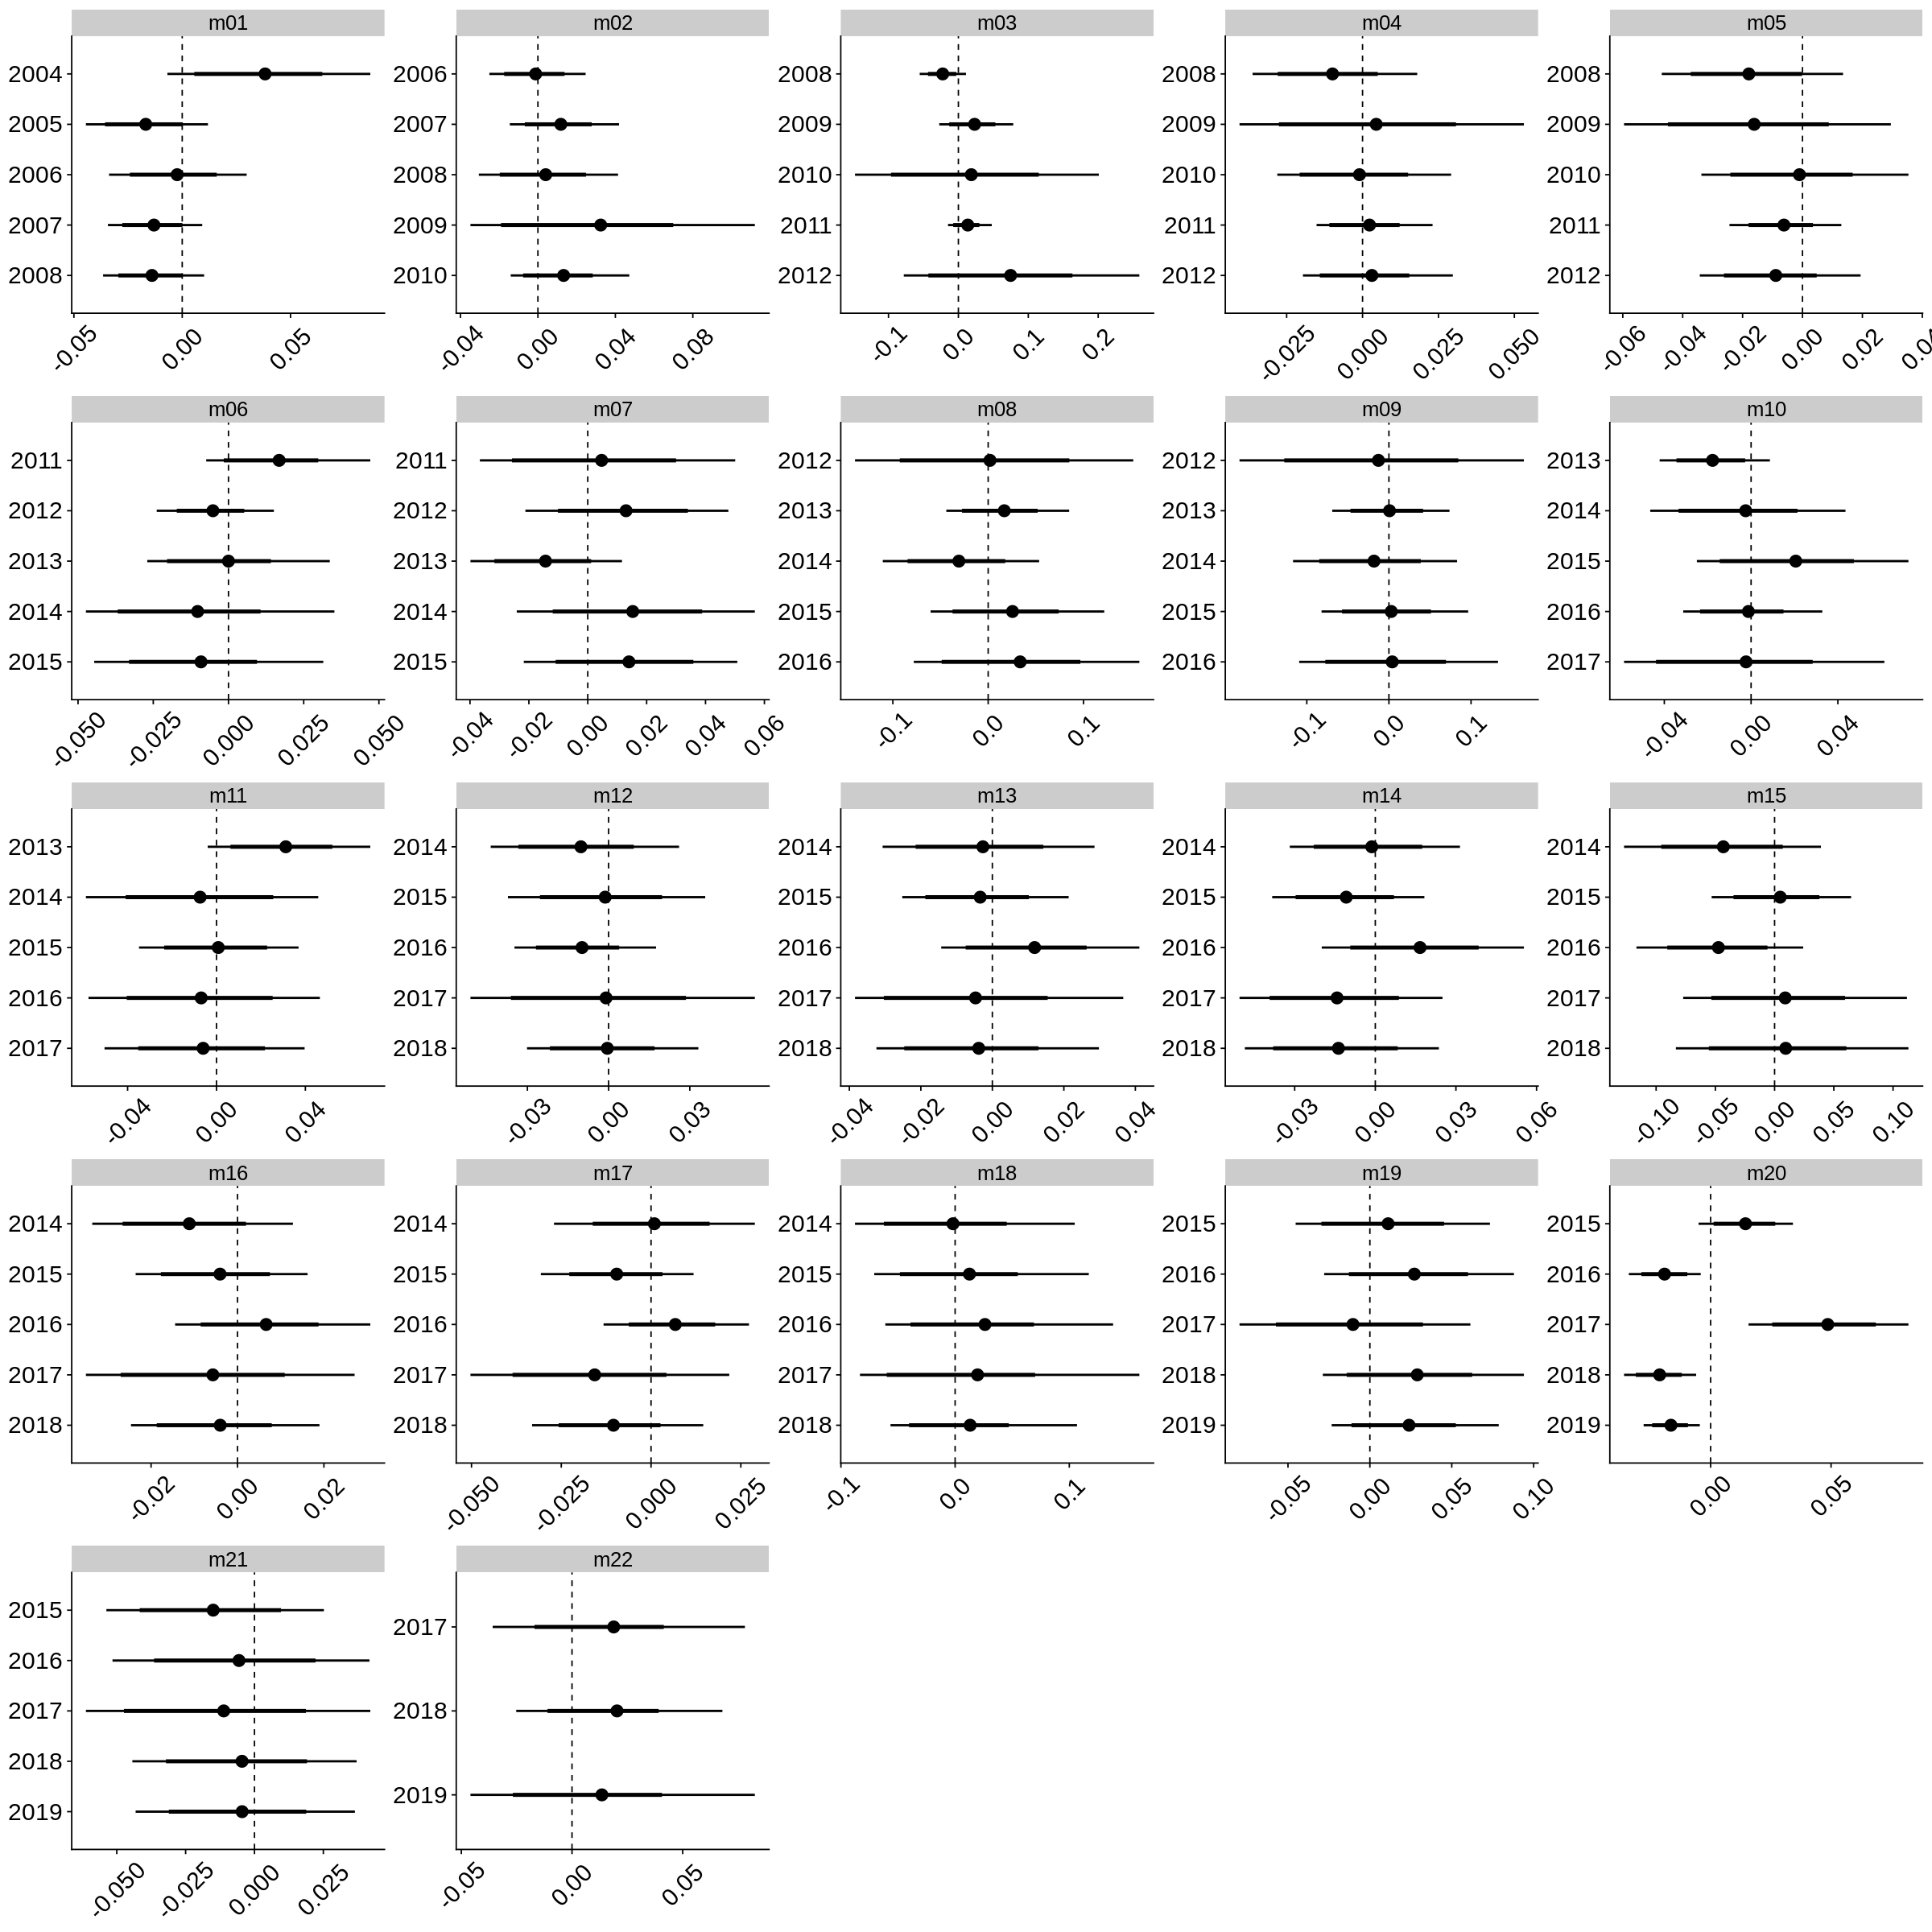

In [24]:
options(repr.plot.width=20, repr.plot.height=20)

##plot results
(dscale_plot_yr <- res_dscale_yr %>%
                         filter(method == 'PSM') %>%
 ggplot() +
 geom_linerange(aes(x = (year_real), ymin = low_80/1e4, ymax = high_80/1e4),  position = position_dodge(width = 1), size = 1.4) + 
 geom_pointrange(aes(x = (year_real), y = mean/1e4, ymin = low_95/1e4, ymax = high_95/1e4), position = position_dodge(width = 1), size = 0.8) + 
 geom_hline(yintercept = 0, linetype = 2) +
 coord_flip() +
 scale_x_reverse() +
 facet_wrap(vars(mine), scales = 'free') + 
 theme_cowplot() +
 theme(text = element_text(size = 18),  
         axis.title=element_blank(), 
         axis.text=element_text(size = 18),
         axis.text.x = element_text(angle = 45, vjust = 0.5)) 
)

In [25]:
ggsave(dscale_plot_yr, filename = 'figures/figure_S4.png',  device = 'png', width = 16, height = 20.7)

## Buffer distance testing

In [ ]:
##read in reuslts of different buffers
beta_df_25 <- read_csv('results/ZINB_posterior_samples_psm.csv')   %>% mutate(method = '25km')
beta_df_10 <- read_csv('results/ZINB_posterior_samples_psm_10km.csv')   %>% mutate(method = '10km')
beta_df_50 <- read_csv('results/ZINB_posterior_samples_psm_50km.csv')   %>% mutate(method = '50km')

In [41]:
beta_df2 <- bind_rows(beta_df_25, beta_df_10, beta_df_50) %>%
                mutate(mine = factor(mine, levels = rev(mines)))

In [ ]:
## convert to results
res_mscale = beta_df2 %>% 
                select(ms_dif_all, mine, method) %>% 
                group_by(method, mine) %>%
                        summarize(mean = inla.emarginal(function(x) x, density(ms_dif_all)), 
                                                        low_95 = inla.hpdmarginal(0.95, density(ms_dif_all))[1], 
                                                        high_95 = inla.hpdmarginal(0.95, density(ms_dif_all))[2],
                                                        low_80 = inla.hpdmarginal(0.80, density(ms_dif_all))[1], 
                                                        high_80 = inla.hpdmarginal(0.80, density(ms_dif_all))[2]) %>%
                        mutate(mine = factor(mine, levels = rev(mine)), ) %>%
                                  ungroup()

In [ ]:
## convert to results
res_dscale = beta_df2 %>% 
                select(ds_dif_all, mine, method) %>% 
                group_by(method, mine) %>%
                        summarize(mean = inla.emarginal(function(x) x, density(ds_dif_all)), 
                                                        low_95 = inla.hpdmarginal(0.95, density(ds_dif_all))[1], 
                                                        high_95 = inla.hpdmarginal(0.95, density(ds_dif_all))[2],
                                                        low_80 = inla.hpdmarginal(0.80, density(ds_dif_all))[1], 
                                                        high_80 = inla.hpdmarginal(0.80, density(ds_dif_all))[2]) %>%
                                                          mutate(mine = factor(mine, levels = rev(mine))) %>%

                                  ungroup()

In [44]:
##add the NA for mine 5 10km to get plot to appear correctly
res_dscale2 <- res_dscale %>% bind_rows(data.frame(method = '10km', mine = 'm05'))  %>%
                mutate(mine = factor(mine, levels = rev(mines)))

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”


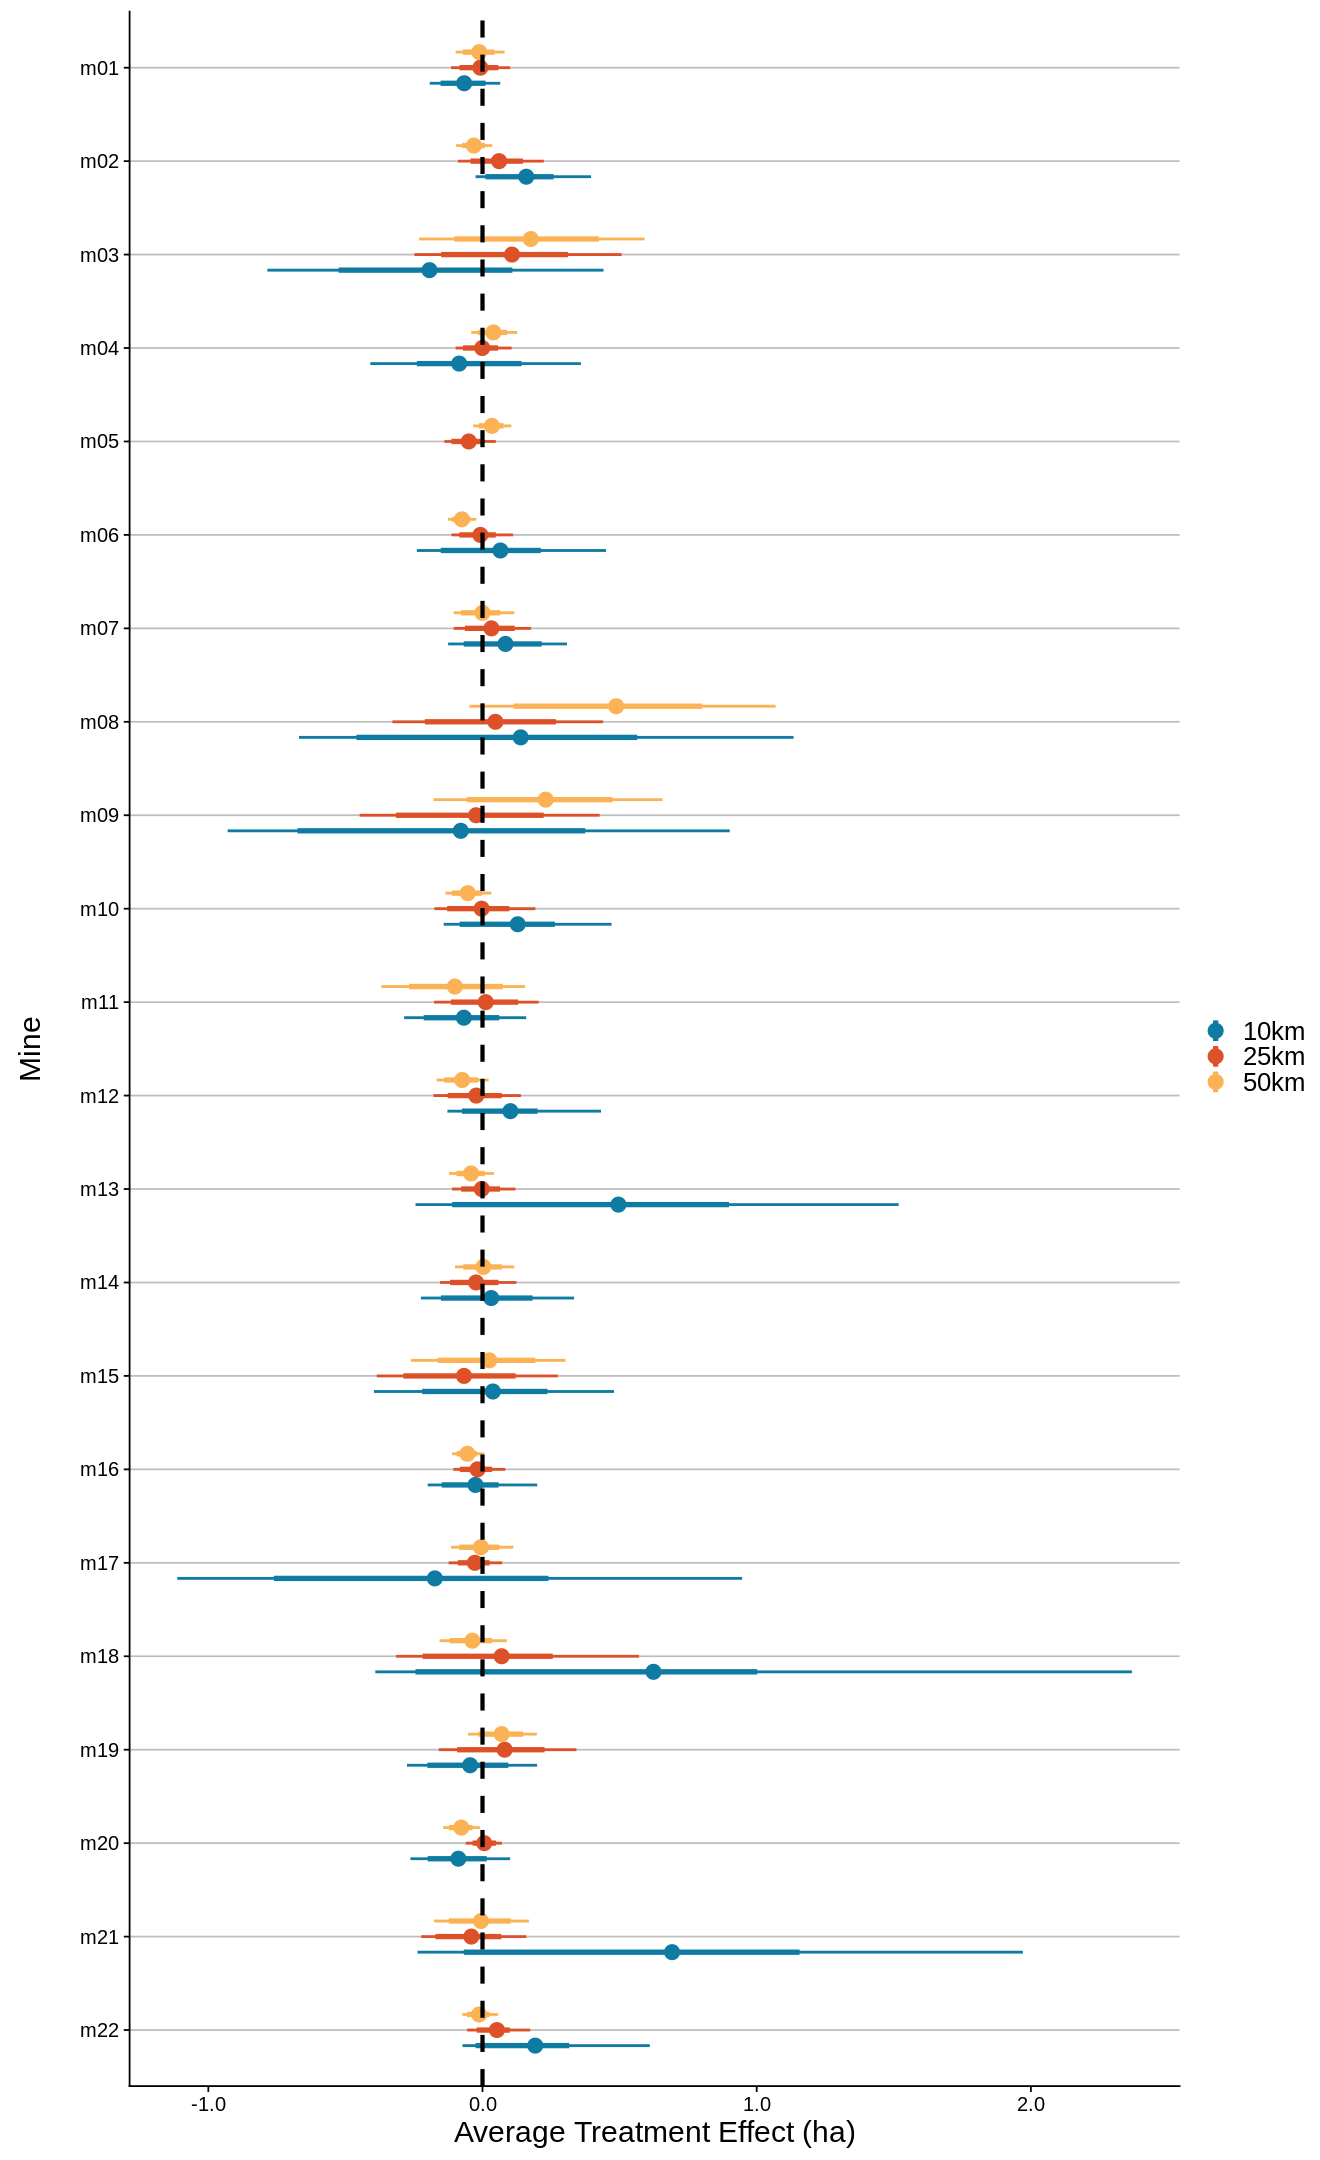

In [54]:
options(repr.plot.width=11, repr.plot.height=18)

##plot results

(dscale_plot2 <- res_dscale2 %>%
 ggplot() +
 geom_linerange(aes(x = (mine), ymin = low_80/1e4, ymax = high_80/1e4, colour = method),  position = position_dodge(width = 0.5), size = 1.5) + 
 geom_pointrange(aes(x = (mine), y = mean/1e4, ymin = low_95/1e4, ymax = high_95/1e4, colour = method),  position = position_dodge(width = 0.5), size = .8) + 
 geom_hline(yintercept = 0, linetype = 2, size = 1.2) +
 coord_flip() +
 theme_cowplot() +
 labs(x = 'Mine', y = 'Average Treatment Effect (ha)') +
 theme(text = element_text(size = 18), 
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 5)), 
            legend.title = element_blank(),
            panel.grid.major.y = element_line(colour = "grey")) +
         scale_y_continuous(labels = comma)  +
         scale_colour_manual(values = c('#0f7ba2','#dd5129','#fab255'))
)

In [55]:
ggsave(dscale_plot2, 'png', filename = 'figures/figure_S6.png', width = 11, height = 14)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”


In [8]:
##varagrams
##create a varaigram to test for resiual SA - this has all years combined
v_all = data.frame()

for (i in seq(1,22)){
    df <- res_df %>% filter(mine == mines[i])
    tryCatch({
        MyData <- data.frame(PR = df$sim_res, xkm = df$xkm, ykm = df$ykm)
        coordinates(MyData) <- c("xkm", "ykm")
        v1 <- variogram(PR ~ 1, MyData, cressie = TRUE) 
        v1$mine <- mines[i]
        v_all <- bind_rows(v1, v_all)
    }, error=function(e){})
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



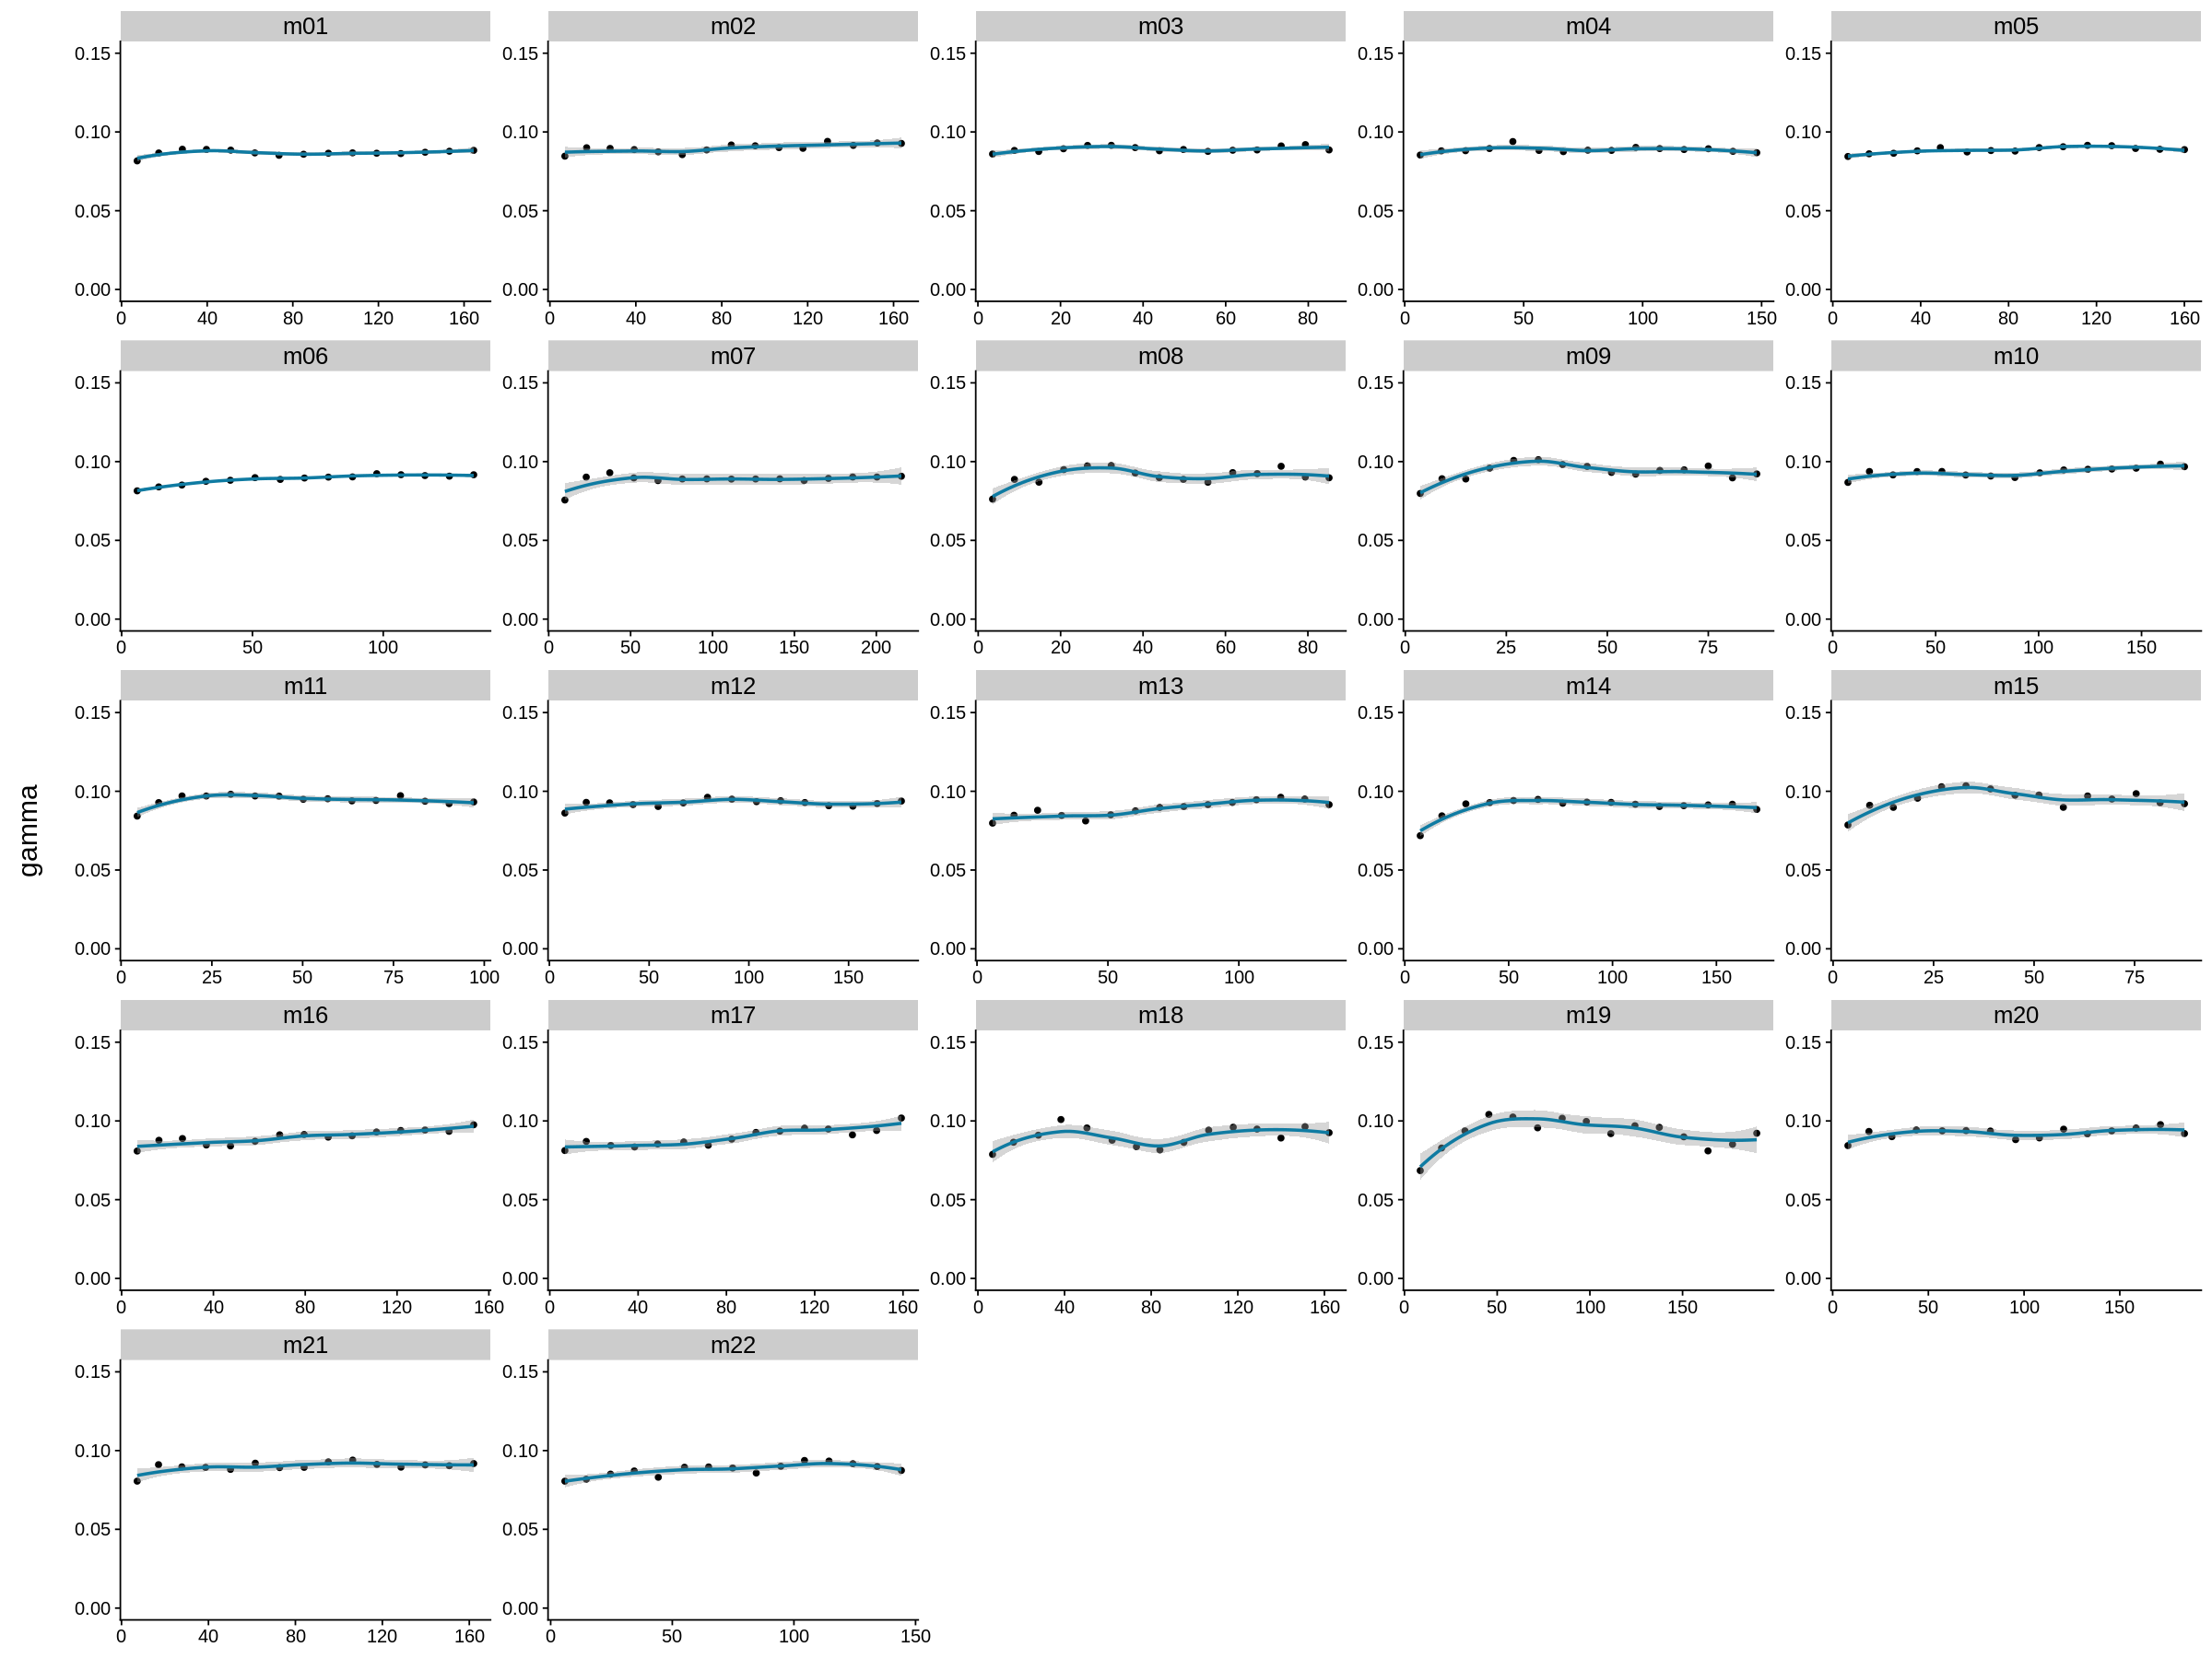

In [9]:
options(repr.plot.width=20, repr.plot.height=15)
(vgrams_all <- v_all %>% 
                 ggplot() + 
                 geom_point(aes(dist, gamma)) + 
                 geom_smooth(aes(dist,gamma), colour = '#0f7ba2') + 
                 ylim(0, 0.15) + 
                 facet_wrap(vars(mine), scales = 'free') + 
                 theme_cowplot() +
                 theme(text = element_text(size = 18), 
                 axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 5)), 
                 legend.title = element_blank(),
                 axis.title.x = element_blank())
)

In [106]:
ggsave(vgrams_all, filename = 'figures/figure_S7.png', device = 'png', width = 16, height = 20.7)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [16]:
##add year and a value 1-5
res_df <- res_df %>%
        group_by(mine) %>%
        mutate(year_int = (year - min(year)) +1) %>%
        ungroup()

In [18]:
##varagrams
##create a varaigram for each year
v = data.frame()

for (i in seq(1,22)){
    df1 <- res_df %>% filter(mine == mines[i])
    tryCatch({
        for(j in seq(1,5)){
            df <- df1 %>% filter(year_int == j)
            MyData <- data.frame(PR = df$sim_res, xkm = df$xkm, ykm = df$ykm)
            coordinates(MyData) <- c("xkm", "ykm")
            v1 <- variogram(PR ~ 1, MyData, cressie = TRUE) 
            v1$mine <- mines[i]
            v1$year_int <- j
            v <- bind_rows(v1, v)
        }
   }, error=function(e){})
}

In [19]:
pal2 <- as.list(met.brewer(name="Egypt", type="discrete"))
#add in fifth colour (purple from Virdis)
pal2[5] <- '#440154FF'
pal2

[[1]]
[1] "#dd5129"

[[2]]
[1] "#0f7ba2"

[[3]]
[1] "#43b284"

[[4]]
[1] "#fab255"

[[5]]
[1] "#440154FF"

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



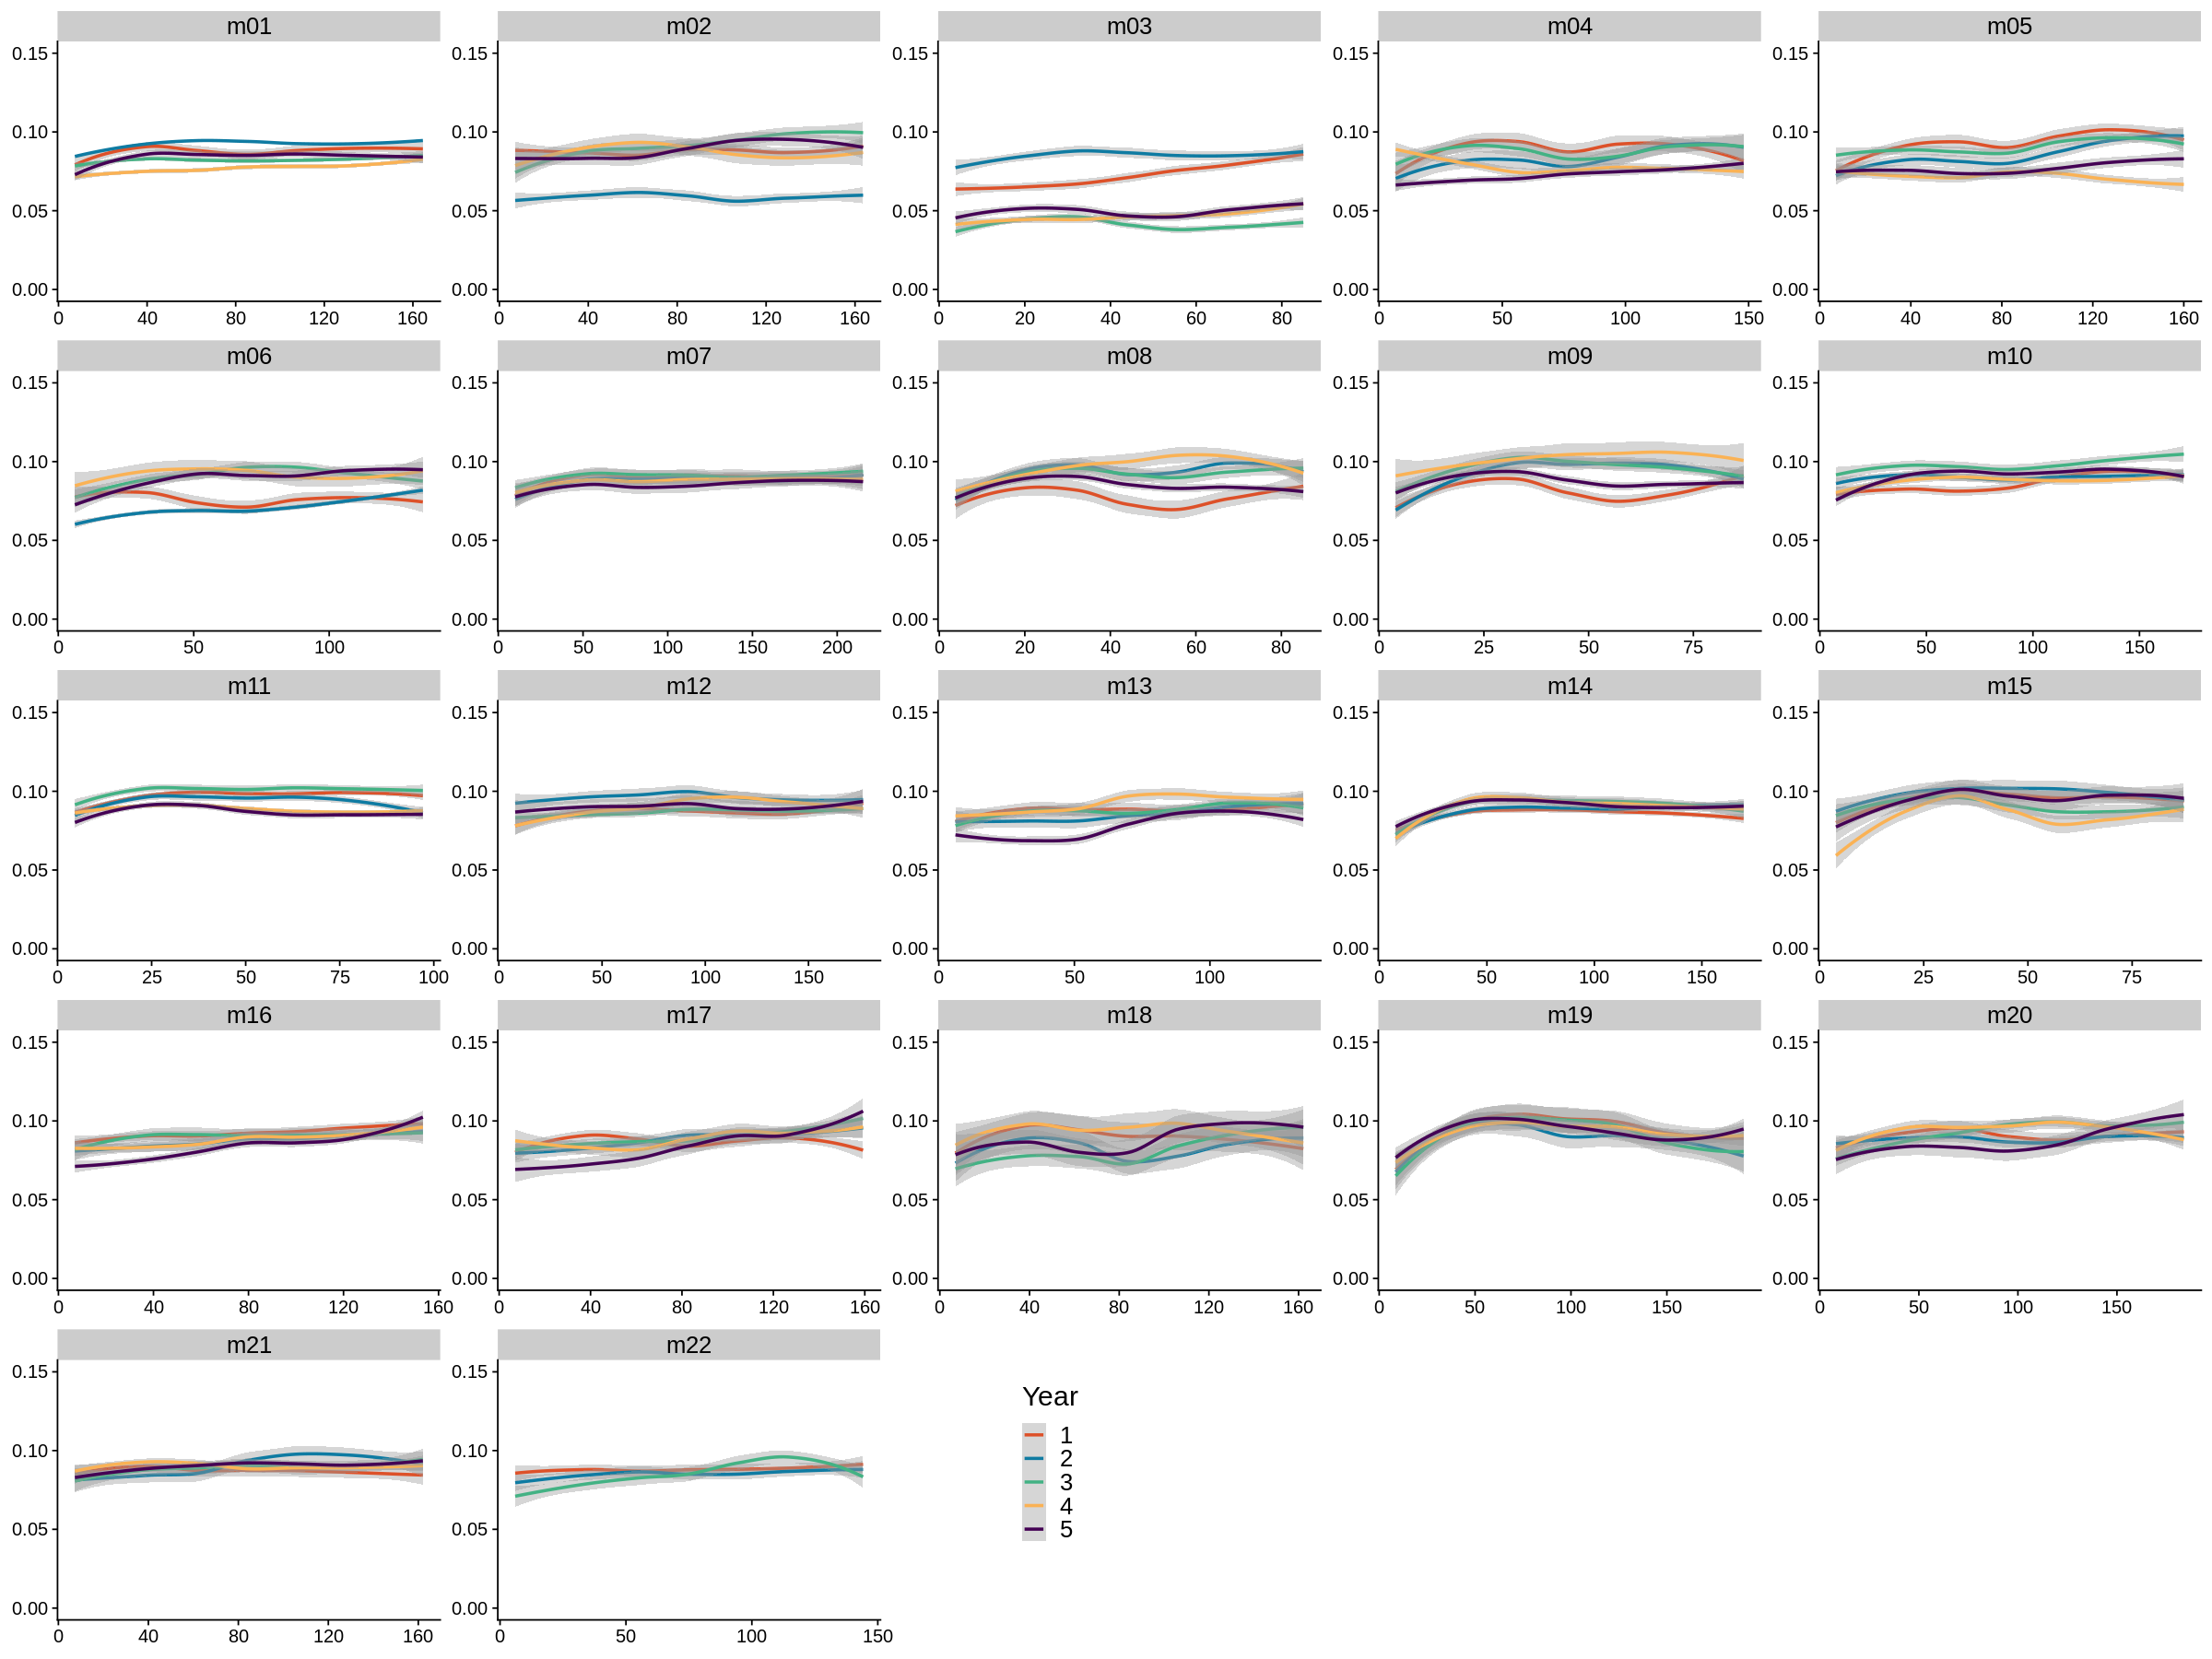

In [20]:
options(repr.plot.width=20, repr.plot.height=15)
(vgrams <- v %>% 
                 ggplot() + 
                 geom_smooth(aes(dist,gamma, colour = as.factor(year_int))) + 
                 ylim (0,0.15) + 
                 facet_wrap(vars(mine), scales = 'free') + 
                 theme_cowplot() +
                 theme(text = element_text(size = 18),
                       axis.title.y = element_blank(), axis.title.x = element_blank(), 
                       legend.position = c(0.45,0.1)) +
                       scale_colour_manual(name = 'Year', values = pal2))


In [88]:
ggsave(vgrams, filename = 'figures/vgrams_psm.png', device = 'png', width = 16, height = 20.7)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

